In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
sns.set_theme(style="whitegrid", font_scale=1.1)

sys.path.append("../EDA")
DATA_PATH = "../instruction/movieReplicationSet.csv"
ALPHA = 0.005

import movie_data_formatter as mdf
import movie_rating_gender as mrgy
import general_functions as gf

df = pd.read_csv(DATA_PATH)
df = mdf.clean_data(df)
processed_data = mdf.convert_to_table(df)



In [ ]:
movies_are_best_enjoyed_alone = processed_data[['movie_name', 'year', 'rating', 'movies_are_best_enjoyed_alone']].dropna(subset=['rating', 'movies_are_best_enjoyed_alone'])

# stats
variation_table = movies_are_best_enjoyed_alone.groupby('movies_are_best_enjoyed_alone')['rating'].agg(['count', 'mean', 'median', 'var', 'std']).reset_index()
print(variation_table)


   movies_are_best_enjoyed_alone  count      mean  median       var       std
0                           -1.0   1926  2.670042     3.0  1.144707  1.069910
1                            0.0  47874  2.837741     3.0  1.116215  1.056511
2                            1.0  62414  2.830383     3.0  1.111605  1.054327


In [ ]:
# Drop the -1 group safely (and keep a copy to avoid SettingWithCopyWarning)
movies_clean = movies_are_best_enjoyed_alone.loc[
    movies_are_best_enjoyed_alone['movies_are_best_enjoyed_alone'] != -1
].copy()

# Ensure the column is int (in case it's float from NaNs) before mapping
movies_clean['movies_are_best_enjoyed_alone'] = (
    movies_clean['movies_are_best_enjoyed_alone'].astype(int)
)

# Map labels
label_map = {1: "Alone", 0: "Socially"}
movies_clean['enjoyed_alone_label'] = movies_clean['movies_are_best_enjoyed_alone'].map(label_map)

# (Optional) Make it an ordered categorical for consistent plotting/printing
cat_order = ["Socially", "Alone"]
movies_clean['enjoyed_alone_label'] = pd.Categorical(
    movies_clean['enjoyed_alone_label'], categories=cat_order, ordered=True
)


/var/folders/9t/kz_xx0px1mxf1wqtzvvb57fc0000gn/T/ipykernel_88692/788817480.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  movies_clean.groupby(['enjoyed_alone_label', 'rating'])


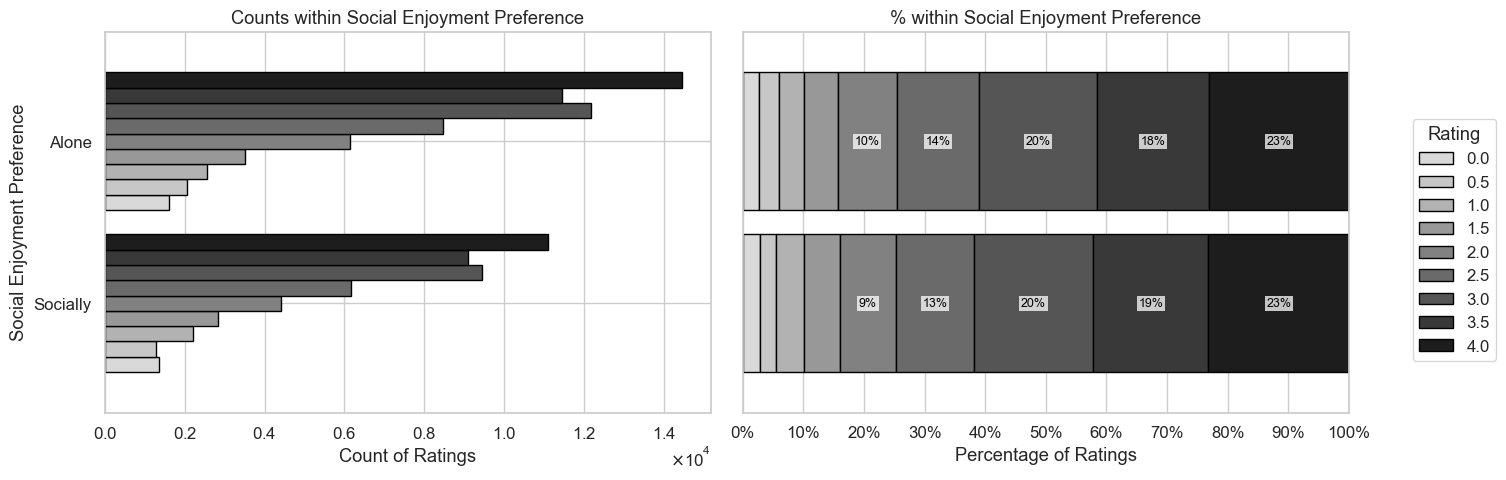

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, ScalarFormatter

# counts table
rating_counts = (
    movies_clean.groupby(['enjoyed_alone_label', 'rating'])
             .size()
             .unstack(fill_value=0)
             .sort_index(axis=1)  # ensure rating columns are ordered
)

# grayscale palette (light → dark)
n_cols = rating_counts.shape[1]
greys = plt.cm.Greys(np.linspace(0.25, 0.90, n_cols))

# (optional) make sure rating columns are treated as ordered categoricals
rating_counts.columns = pd.Categorical(rating_counts.columns, ordered=True)
rating_counts = rating_counts.sort_index(axis=1)

# per-group percentages (rows sum to 1)
rating_percentages = rating_counts.div(rating_counts.sum(axis=1), axis=0)

# overall rating shares across all genders (for the Δ labels)
overall_share = rating_counts.sum(axis=0) / rating_counts.values.sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# --- LEFT: counts (horizontal grouped) ---
rating_counts.plot(kind='barh', ax=axes[0], width=0.85, color=greys, edgecolor='black')
axes[0].set_title('Counts within Social Enjoyment Preference')
axes[0].set_xlabel('Count of Ratings')
axes[0].set_ylabel('Social Enjoyment Preference')

sf = ScalarFormatter(useMathText=True)
sf.set_scientific(True)
sf.set_powerlimits((0, 0))      # always use scientific notation
axes[0].xaxis.set_major_formatter(sf)
axes[0].ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)

# --- RIGHT: % within gender (horizontal 100% stacked) ---
rating_percentages.plot(kind='barh', ax=axes[1], stacked=True, width=0.85,
                        color=greys, edgecolor='black')
axes[1].set_title('% within Social Enjoyment Preference')
axes[1].set_xlabel('Percentage of Ratings')
axes[1].set_ylabel('Social Enjoyment Preference')
axes[1].xaxis.set_major_formatter(PercentFormatter(1.0))
axes[1].set_xlim(0, 1)
# step 0.1
axes[1].xaxis.set_ticks(np.arange(0, 1.1, 0.1))

# ===== In-box annotations on percentage panel =====
min_width = 0.06  # label only segments >= 6% of the row width
y_positions = np.arange(len(rating_percentages.index))
cum_left = np.zeros(len(rating_percentages), dtype=float)

for col in rating_percentages.columns:
    widths = rating_percentages[col].values                         # segment widths per gender
    centers_x = cum_left + widths / 2.0
    delta_pp = (rating_percentages[col] - overall_share[col]) * 100 # Δ vs overall in p.p.
    labels = [f"{p:,.0%}" for p, d in zip(widths, delta_pp.values)]

    for y, w, x_center, label in zip(y_positions, widths, centers_x, labels):
        if w >= min_width:
            axes[1].text(
                x_center, y, label,
                ha='center', va='center', fontsize=9, color='black',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.75, pad=1.2)
            )

    cum_left += widths

# Shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
axes[0].get_legend().remove()
axes[1].get_legend().remove()
fig.legend(handles, labels, title='Rating', loc='center left', bbox_to_anchor=(1.01, 0.5))

# remove the y label on the right panel and the y-axis values on the left panel
axes[1].set_ylabel('')
axes[1].set_yticklabels([])


plt.tight_layout()

# save to pdf
plt.savefig('../figures/social_enjoyment_rating_distribution.pdf', bbox_inches='tight')


In [14]:
def total_variation_distance(p, q):
    # make sure they all have 0, 0.5, 1, .., 4 
    all_values = np.arange(0, 4.5, 0.5)
    p = p.reindex(all_values, fill_value=0)
    q = q.reindex(all_values, fill_value=0)
    p, q = np.asarray(p, dtype=float), np.asarray(q, dtype=float)
    p, q = p / p.sum(), q / q.sum()
    return 0.5 * np.sum(np.abs(p - q))

In [15]:
df_gender_movie = movies_clean.groupby(['movie_name', 'year'])
df_gender_movie.size()

n_movies = len(df_gender_movie)

results = pd.DataFrame(columns=['prop', 'mw_p_value', 'mw_u_stat'])

for name, group in df_gender_movie:
    movie_name = name[0] + " (" + str(name[1]) + ")"
    # drop NA ratings
    ratings = group['rating'].dropna()
    
    # Split ratings by gender
    alone_ratings = ratings[group['enjoyed_alone_label'] == 'Alone'].astype(float)
    socially_ratings = ratings[group['enjoyed_alone_label'] == 'Socially'].astype(float)

    if len(alone_ratings) > 0 and len(socially_ratings) > 0:

        # check if ratings have na values
        if alone_ratings.isna().sum() > 0 or socially_ratings.isna().sum() > 0:
            print(f"NA values found in ratings for movie: {movie_name}")
            continue


        prop = total_variation_distance(alone_ratings.value_counts().sort_index(), socially_ratings.value_counts().sort_index())

        # Mann-Whitney U Test

        u_stat, p_value_mw = stats.mannwhitneyu(alone_ratings, socially_ratings, alternative='two-sided')

        results.loc[movie_name] = [prop, p_value_mw, u_stat]


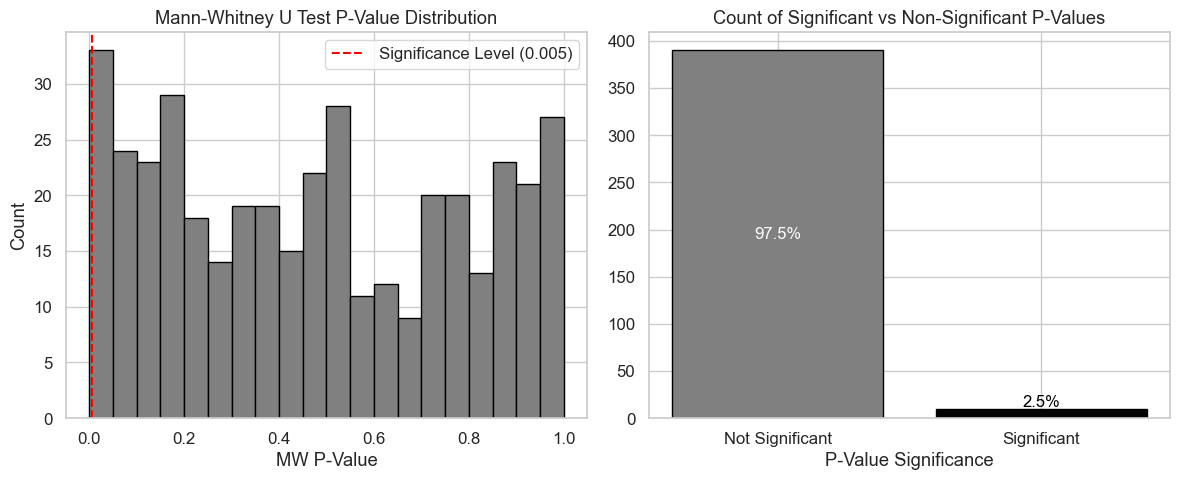

In [18]:
# one figure 
fig, ax = plt.subplots(1,2, figsize=(12, 5), dpi=100)

# distbution of p-values
results['mw_p_value'].hist(bins=20, ax=ax[0], color='gray', edgecolor='black')
ax[0].axvline(x=ALPHA, color='red', linestyle='--', label='Significance Level ({})'.format(ALPHA))
ax[0].set_title('Mann-Whitney U Test P-Value Distribution')
ax[0].set_xlabel('MW P-Value')
ax[0].set_ylabel('Count')
ax[0].legend()

# count of significant p-values and non-significant p-values
sig = results['mw_p_value'] < ALPHA
nonsig = results['mw_p_value'] >= ALPHA
ax[1].bar(['Not Significant', 'Significant'], [nonsig.sum(), sig.sum()], color=['gray', 'black'], edgecolor='black')
ax[1].set_title('Count of Significant vs Non-Significant P-Values')
ax[1].set_xlabel('P-Value Significance')

# annotations of the % 
total = len(results)
ax[1].text(0, nonsig.sum()/2, f"{(nonsig.sum()/total)*100:.1f}%", ha='center', va='center', color='white', fontsize=12)
ax[1].text(1, sig.sum()/2 + 12, f"{(sig.sum()/total)*100:.1f}%", ha='center', va='center', color='black', fontsize=12)

plt.tight_layout()
plt.savefig('../figures/social_enjoyment_mw_pvalue_distribution.pdf', bbox_inches='tight')

In [19]:
# proportion of significant movies and effect sizes
proportion_mw_significant = (results['mw_p_value'] < ALPHA).mean()

print(f"Proportion of movies with significant Mann-Whitney U test results (p < {ALPHA}): {proportion_mw_significant:.4f}")


Proportion of movies with significant Mann-Whitney U test results (p < 0.005): 0.0250
